# Tutorial
## [How to do Novelty Detection in Keras with Generative Adversarial Network](https://www.dlology.com/blog/how-to-do-novelty-detection-in-keras-with-generative-adversarial-network-part-2/) | DLology

This notebook is for test phase Novelty Detection. To Train the model, run this first.
```bash
python models.py
```

It is recommended to understand how the model works in general before continuing the implementation. 

→ [How to do Novelty Detection in Keras with Generative Adversarial Network (Part 1)](https://www.dlology.com/blog/how-to-do-novelty-detection-in-keras-with-generative-adversarial-network/)


In [1]:
from utils import *
from kh_tools import *
import models
import imp
imp.reload(models)
from models import ALOCC_Model
from keras.datasets import mnist

from keras.losses import binary_crossentropy
from keras import backend as K

import numpy as np
from PIL import Image
from glob import glob
import os.path as osp
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
self = ALOCC_Model(dataset_name='virat', 
                   dataset_address='/home/zal/Devel/Vehice_Action_Classifier/output/alocc_data.npz', 
                   input_height=64, input_width=64, 
                   output_height=64, output_width=64,
                   is_training = False, c_dim=1)


 adversarial_model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
R (Model)                    (None, 64, 64, 1)         320993    
_________________________________________________________________
D (Model)                    (None, 1)                 272385    
Total params: 593,378
Trainable params: 320,545
Non-trainable params: 272,833
_________________________________________________________________


## Choose a stopping criterion
The training procedure is stopped when R successfully maps noisy images to clean images carrying the concept of the target class.  When R can reconstruct its input with minimum error. In the following case, we pick the epoch 3.

In [4]:
dataset = np.load(open(self.dataset_address, 'rb'))
X_train, y_train = dataset['images'], dataset['labels']
X_train = X_train / 255.0

## Test the reconstruction loss and Discriminator output
The `abnormal` image has a **`larger` reconstruction loss** and **`smaller` discriminator output value**.

In [5]:
def test_reconstruction(label, data_index = 11, size=64):
    specific_idx = np.where(y_train == label)[0]
    if data_index >= len(X_train):
        data_index = 0
    data = X_train[specific_idx].reshape(-1, size, size, 1)[data_index:data_index+1]
    
    dx = self.discriminator.predict(data)[0][0]
    drx = self.discriminator.predict(self.generator.predict(data))[0][0]
    
    if drx > dx:
        print('NORMAL')
    else:
        print('ABNORMAL')
    
    print('D(X)   =', dx)
    print('D(R(X))=', drx)
    
    model_predicts = self.adversarial_model.predict(data)
    
    fig = plt.figure(figsize=(8, 8))
    columns = 1
    rows = 2
    fig.add_subplot(rows, columns, 1)
    input_image = data.reshape((size, size))
    reconstructed_image = model_predicts[0].reshape((size, size))
    plt.title('Input')
    plt.axis('off')
    plt.imshow(input_image, label='Input', cmap='gray')
    fig.add_subplot(rows, columns, 2)
    plt.title('Reconstruction')
    plt.axis('off')
    plt.imshow(reconstructed_image, label='Reconstructed', cmap='gray')
    plt.show()
    # Compute the mean binary_crossentropy loss of reconstructed image.
    y_pred = K.variable(reconstructed_image)
    y_true = K.variable(input_image)
    error = K.eval(binary_crossentropy(y_true, y_pred)).mean()
    print('Reconstruction loss:  ', error)
    print('Discriminator Output: ', model_predicts[1][0][0])

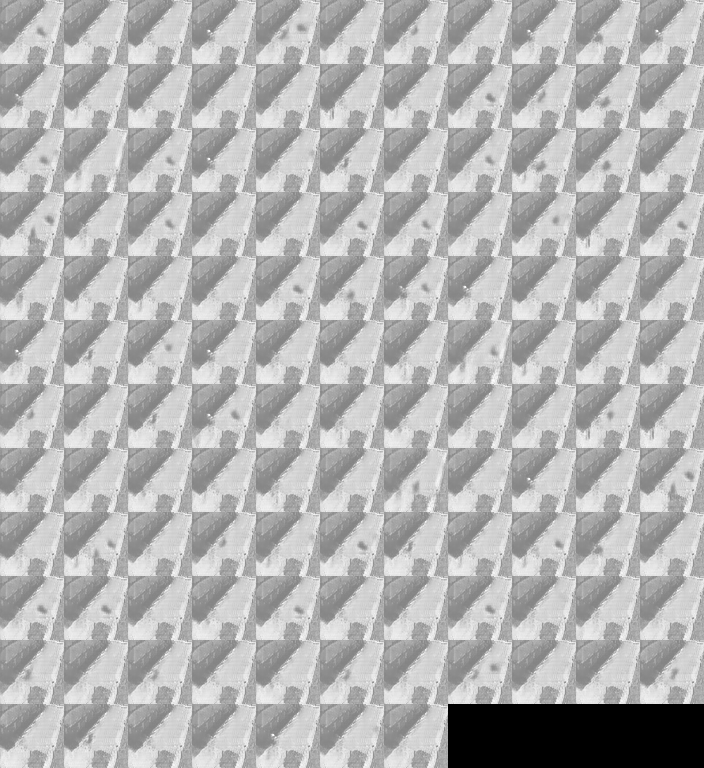

In [86]:
# This image was generated at the end of the models.py training procedure to help pick a ending epoch to load. 
from IPython.display import Image as displayImage
displayImage(filename='sample/00/train.png')

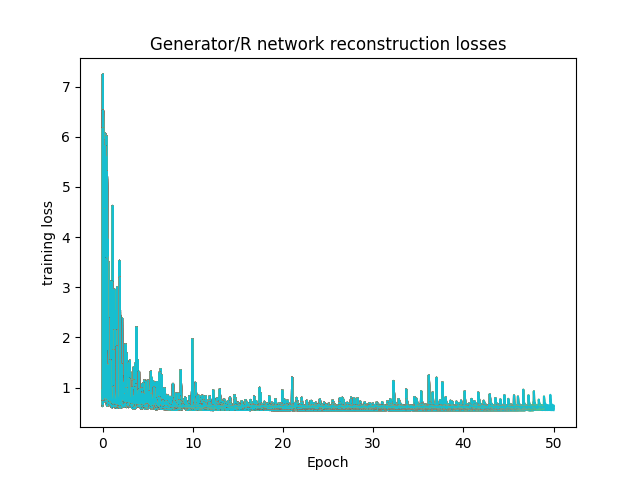

In [96]:
# This image was generated at the end of the models.py training procedure to help pick a ending epoch to load. 
from IPython.display import Image as displayImage
displayImage(filename='plot_g_recon_losses.png')

ABNORMAL
D(X)   = 1.0
D(R(X))= 1.0


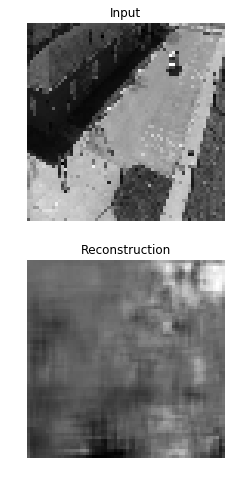

Reconstruction loss:   0.70386326
Discriminator Output:  1.0
ABNORMAL
D(X)   = 1.0
D(R(X))= 1.0


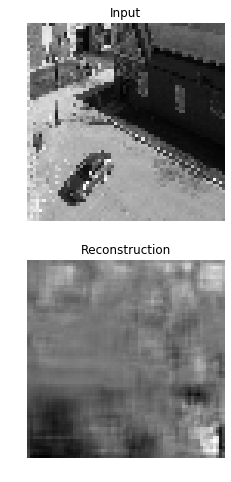

Reconstruction loss:   0.72115386
Discriminator Output:  1.0
ABNORMAL
D(X)   = 1.0
D(R(X))= 1.0


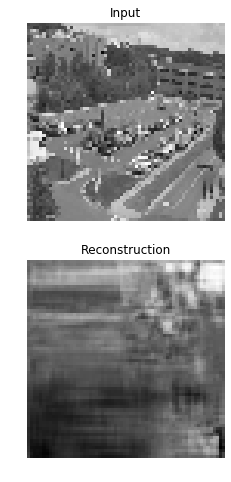

Reconstruction loss:   0.72329384
Discriminator Output:  1.0
ABNORMAL
D(X)   = 1.0
D(R(X))= 1.0


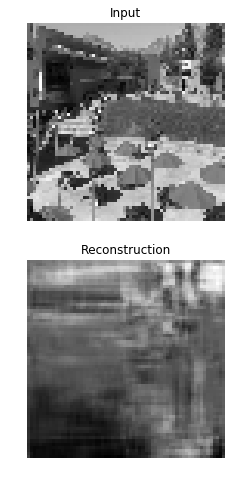

Reconstruction loss:   0.7411841
Discriminator Output:  1.0
ABNORMAL
D(X)   = 1.0
D(R(X))= 1.0


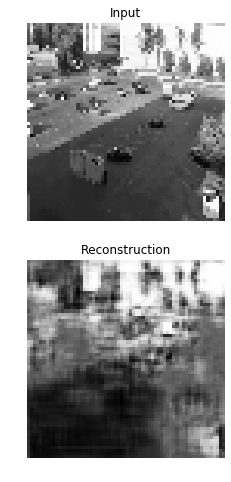

Reconstruction loss:   0.5913745
Discriminator Output:  1.0


In [117]:
i = 4
self.adversarial_model.load_weights('./checkpoint/{:02d}/ALOCC_Model_13.h5'.format(i))
for i in range(5):
    test_reconstruction(i, 95)

### Test on VIRAT dataset for scene detection and outlier detection

In [ ]:
def test_image(img_path, size=64):
    img = Image.open(img_path).resize((size, size)).convert('L')
    data = np.asarray(img, dtype=np.uint8) / 255.0
    data = data.reshape(-1, size, size, 1)    
    model_predicts = self.adversarial_model.predict(data)
    
    fig = plt.figure(figsize=(8, 8))
    columns = 1
    rows = 2
    fig.add_subplot(rows, columns, 1)
    input_image = data.reshape((size, size))
    reconstructed_image = model_predicts[0].reshape((size, size))
    plt.title('Input')
    plt.axis('off')
    plt.imshow(input_image, label='Input', cmap='gray')
    fig.add_subplot(rows, columns, 2)
    plt.title('Reconstruction')
    plt.axis('off')
    plt.imshow(reconstructed_image, label='Reconstructed', cmap='gray')
    plt.show()
    # Compute the mean binary_crossentropy loss of reconstructed image.
    y_true = K.variable(input_image)
    y_pred = K.variable(reconstructed_image)
    error = K.eval(binary_crossentropy(y_pred, y_true)).mean()
    print('Reconstruction loss:  ', error)
    print('Discriminator Output: ', model_predicts[1][0][0])

In [ ]:
def eval_image(model, img_path, size=64):
    img = Image.open(img_path).resize((size, size)).convert('L')
    data = np.asarray(img, dtype=np.uint8) / 255.0
    data = data.reshape(-1, size, size, 1)
    model_predicts = model.predict(data)
    
    in_img = data.reshape((size, size))
    r_img = model_predicts[0].reshape((size, size))    
    r_error = K.eval(binary_crossentropy(K.variable(r_img), K.variable(in_img))).mean()
    d_score = model_predicts[1][0][0]
    
    return (in_img*255, r_img*255.0, r_error, d_score)

In [ ]:
def eval_images(model, img_paths, size=64):
    imgs = [Image.open(ip).resize((size, size)).convert('L') for ip in img_paths]
    imgs = np.stack(imgs)
    data = np.asarray(imgs, dtype=np.uint8) / 255.0
    data = data.reshape(-1, size, size, 1)
    model_predicts = model.predict(data)
    
    r_imgs = [model_predicts[0][i].reshape((size, size))*255.0 for i in range(len(model_predicts[0]))]
    return imgs, r_imgs

In [ ]:
def predict_images(model, img_paths, size=64):
    imgs = [Image.open(ip).resize((size, size)).convert('L') for ip in img_paths]
    imgs = np.stack(imgs)
    data = np.asarray(imgs, dtype=np.uint8) / 255.0
    data = data.reshape(-1, size, size, 1)
    return model.predict(data)

In [ ]:
def get_model_eval_tile(model, img_paths, save_path=None):
    _, r_imgs = eval_images(model, img_paths)
    return np.hstack(r_imgs).astype(np.uint8)

In [ ]:
img_path_list = sorted(glob(osp.join('/home/zal/Devel/Vehice_Action_Classifier/output/[0-9]*.jpg')), key=lambda x: int(osp.splitext(osp.basename(x))[0]))
print('\n'.join(img_path_list))

In [ ]:
imgs, r_imgs = eval_images(self.adversarial_model, img_path_list)
stacked_imgs = np.hstack(imgs).astype(np.uint8)
stacked_rimgs = np.hstack(r_imgs).astype(np.uint8)
stacked_all = np.vstack([stacked_imgs, stacked_rimgs])
Image.fromarray(stacked_imgs).show()
Image.fromarray(stacked_rimgs).show()
Image.fromarray(stacked_all).show()

In [ ]:
img, r_img, r_error, d_score = eval_image(self.adversarial_model, '/home/zal/Devel/Vehice_Action_Classifier/output/1.jpg')
stacked_img = np.hstack([img, r_img]).astype(np.uint8)
plt.axis('off')
plt.imshow(stacked_img, cmap='gray')

### Multiple models trained for 19 scenes

The network was trained for all 19 scenes. Need to load it and get the strip for each one of them

So first we are going to load the models.

In [ ]:
def load_models(num_models, checkpoint_dir, epoch):
    models = []
    for sid in range(num_models):
        model = ALOCC_Model(dataset_name='virat',
                                dataset_address='/home/zal/Devel/Vehice_Action_Classifier/output/alocc_data.npz',
                                input_height=64,input_width=64, output_height=64, output_width=64,
                               is_training=False, c_dim=1)
        model.adversarial_model.load_weights(osp.join(checkpoint_dir, '%02d'%sid, 'ALOCC_Model_%02d.h5'%epoch))
        models.append(model.adversarial_model)
    return models

In [ ]:
models = load_models(5, './checkpoint', 49)

In [ ]:
models = [m.adversarial_model for m in models]

In [ ]:
eval_tiles = []
num_models = 5
for sid in range(num_models):
    reconstruction_tile = get_model_eval_tile(models[sid], img_path_list[:num_models])
    eval_tiles.append(reconstruction_tile)

input_imgs = [Image.open(ip).resize((64, 64)).convert('L') for ip in img_path_list[:num_models]]
Image.fromarray(np.hstack(input_imgs)).show()
Image.fromarray(np.vstack(eval_tiles)).show()

In [ ]:
self.adversarial_model.load_weights('./checkpoint/00/ALOCC_Model_29.h5')
test_reconstruction(0)